In [1]:
# Auto reload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
dataset_dir = '/robin-west/womd_processed/vbd/training/processed'
ckpt_path = '/robin-west/VBD/weights/epoch=27.ckpt'
anchor_path = '/robin-west/VBD/vbd/data/cluster_64_center_dict.pkl'

# Generating Traffic Scenarios with Goal Guidance
This notebook is a simple example of how to generate traffic scenarios that certain agents are conditioned with goals. In this example, goals are generated from a trajectory predicition model. In reality, goals can be obtained from other sources, such as human instructions, or planner.

In [7]:
## Import Dependencies
import torch
import numpy as np

import sys
workspace_path = "/robin-west/VBD"
sys.path.append(f"{workspace_path}")
from vbd.model.utils import set_seed
set_seed(0)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')

from waymax import dynamics
from waymax.config import EnvironmentConfig, ObjectType
from vbd.waymax_visualization.plotting import plot_state
from vbd.data.data_utils import data_process_scenario, tf_preprocess, tf_postprocess, data_collate_fn
from waymax import dataloader
from waymax.config import DataFormat
import mediapy
import pickle

MAX_NUM_OBJECTS = 32
MAX_POLYLINES = 256
NUM_POINTS_POLYLINE = 30


## Set Environment
env_config = EnvironmentConfig(
    # Ensure that the sim agent can control all valid objects.
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=11,
    max_num_objects=128,
)

from vbd.sim_agent.waymax_env import WaymaxEnvironment
from vbd.data.waymax_utils import smooth_scenario
dynamics_model = dynamics.StateDynamics()
env = WaymaxEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
    log_replay = True,
)

# Create Dataset
from vbd.data.dataset import WaymaxTestDataset

dataset = WaymaxTestDataset(
    data_dir = dataset_dir,
    anchor_path = anchor_path,
    max_object=MAX_NUM_OBJECTS,
)
# Load model
from vbd.sim_agent.sim_actor import VBDTest, sample_to_action
print('Load model', ckpt_path)
model = VBDTest.load_from_checkpoint(ckpt_path,map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()

model.reset_agent_length(MAX_NUM_OBJECTS)

Load model /robin-west/VBD/weights/epoch=27.ckpt


In [8]:
def plot_results(init_state, is_controlled, denoiser_output, h=-1, t=-1, video = False, **kwargs):
    if 'history' in denoiser_output:
        # traj_input = denoiser_output['history']['denoiser_output_history']['noised_trajs'][h, 0, ...]
        traj_pred = denoiser_output['history']['denoiser_output_history']['denoised_trajs'][h, 0, ...] # [A,T,D]
    else:
        # traj_input = denoiser_output['noised_trajs'][0, ...].detach().cpu().numpy()
        traj_pred = denoiser_output['denoised_trajs'][0, ...].detach().cpu().numpy()
    
    state_logs = [init_state]
    current_state = init_state
    for i in range(init_state.remaining_timesteps):
        action_sample = traj_pred[:, i, :]
        action = sample_to_action(action_sample, is_controlled)
        current_state = env.step_sim_agent(current_state, [action])
        state_logs.append(current_state)

    mediapy.show_image(plot_state(state_logs[t], **kwargs))

## Load one scenario and visualize the log replay

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


""

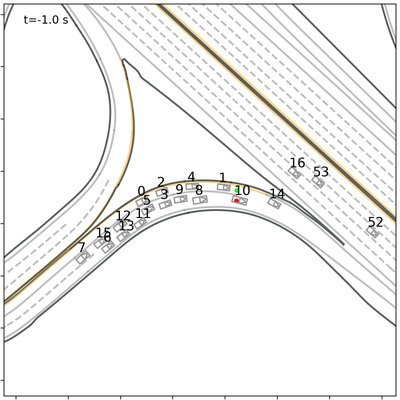

In [9]:
scenario_id, scenario, _ = dataset.get_scenario_by_id('339ff3d43222b4e5')

scenario.sim_trajectory = scenario.log_trajectory
mediapy.show_image(plot_state(scenario))

## Open-loop Roll Out without Goal Guidance

In [10]:
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Reset the environment
init_state = env.reset(scenario)

current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Update object meta data
print(selected_agents)

state_logs = [current_state]

for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=False,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    action_sample = traj_pred[:, t, :]
    action = sample_to_action(action_sample, is_controlled, agents_id=selected_agents)
    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Replan at  10


Diffusion: 100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


In [11]:
imgs = [plot_state(state) for state in state_logs]
mediapy.show_video(imgs, fps=10)

## Roll Out with Goal Guidance

In [9]:
from vbd.sim_agent.guidance_metrics import TrackingReward
model.early_stop = 0 # Stop Diffusion Early From 100 to X

model.skip = 1 # Skip Alpha 
model.cuda()
model.reward_func = torch.nn.ModuleList([
    TrackingReward(),
])
model.guidance_iter = 10
model.guidance_start = 50
model.guidance_end = 1
model.gradient_scale = 0.5
model.scale_grad_by_std = False
model.guidance_func = model.guidance

init_state = env.reset(scenario)
current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Assign goals as reference
ref = np.zeros((1,dataset.max_object,80,2))
ref[0,5,:,:] = np.array([5900, -3123])
ref = torch.from_numpy(ref).to(model.device)

weight = torch.zeros((1,dataset.max_object,80)).to(model.device)
weight[0,5,-1] = 1.0 # we only care about agent 5

# Generate a sample
state_logs = [current_state]

batch = dataset.__collate_fn__([sample])
pred = model.sample_denoiser(batch, traj_ref=ref, weight=weight)
traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

for t in range(current_state.remaining_timesteps):
    action_sample = traj_pred[:, t, :]
    action = sample_to_action(action_sample, is_controlled, agents_id=selected_agents)
    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)


Diffusion: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


In [11]:
from vbd.waymax_visualization.utils import img_from_fig

goal = ref[0,5,-1,:].cpu().numpy()

imgs = []
for state in state_logs:
    fig, ax = plot_state(state, return_ax=True)
    ax.scatter(goal[0], goal[1], color='red', marker='x')
    imgs.append(mediapy.resize_image(img_from_fig(fig), (400, 400)))
                
mediapy.show_video(imgs, fps=10)